# Using Support Vector Regression to Predict NextEra Energy Stock Prices 

In [144]:
# Importing needed packages
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import warnings

In [134]:
# Downloading NextEra Energy(NEE) data from Yahoo Finance
ticker = ["NEE"]
start_date = "2019-11-01"
end_date = "2020-01-13"
dt = data.DataReader(ticker, data_source = 'yahoo', start = start_date, end = end_date)


In [135]:
# Preparing the data

# Take only the closing price of the NextEra Energy stock data
dt = dt[['Close']]
# Turn Index column into a column to be later used as the independent variable
dt['Dates'] = dt.index
# Create a new column of the number of days in a new format to that vector regression 
#can be performed
dt['date_delta'] = (dt['Dates'] - dt['Dates'].min())/np.timedelta64(1,'D')
# Split the data in the dependent variable y - stock prices and independent variable x - date_delta
X = dt.iloc[:, 2].values.reshape(-1,1)
y = dt.iloc[:, 0].values.reshape(-1,1)


# Split data into training and testing data. The testing data will be the last five days of the
# time series 2020-01-08 to 2020-01-13 i.e. - days 67,68,69,70,73
X_train = X[:-5,:]
X_test = X[-5:,:]
y_train = y[:-5,:]
y_test = y[-5:,:]

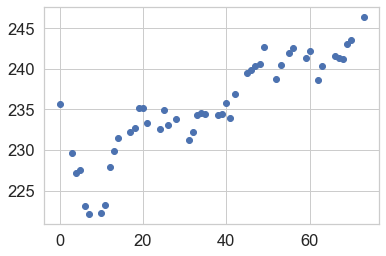

In [136]:
# Plotting X and y data to get a visualization of the data
%matplotlib inline
plt.scatter(X, y)
plt.show()

Based on the visualization of the data, a radial basis function as the kernel of the support vector regressor is the most likely candidate to provide the most optimal fit to the training data. For completeness linear and polynomial kernels will also be considered.

In [206]:
# Hyperparameter tuning with GridSearchCV. Due to the smallness of the dataset a fold of k=15 
# will be used in the cross validation.

warnings.filterwarnings("ignore")

y_partune = np.ravel(y_train)
Cs = [1,10,100,1000]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVR(), param_grid, cv=15)
grid_search.fit(X_train, y_partune)
grid_search.best_params_


{'C': 100, 'gamma': 0.01}

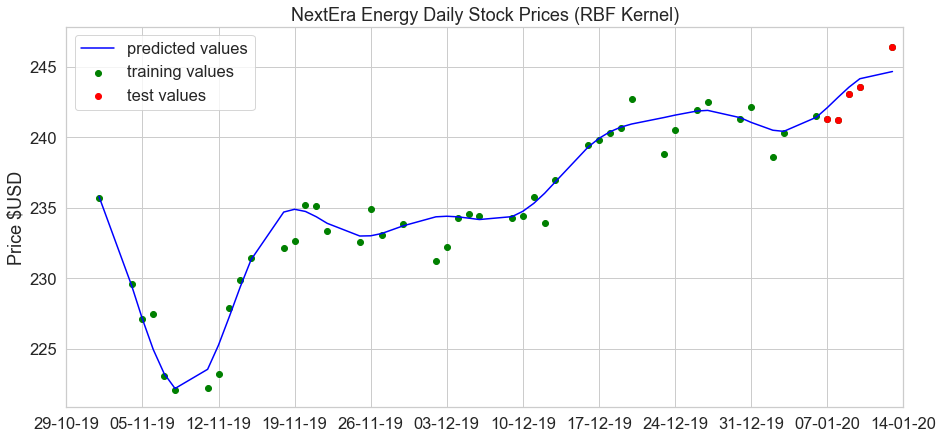

In [208]:
#Using the hyperparameters chosen by GridseachCV the SVR regressor is fit with a rbf kernel
# and a graph of the results is produced.

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.01)
svr_rbf.fit(X_train, y_partune)
y_pred_rbf  = svr_rbf.predict(X)

%matplotlib inline
sns.set(font_scale=1.5, style="whitegrid")
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dt['Dates'], y, color = 'green', label = 'training values')
ax.scatter(dt.iloc[-5:,1], dt.iloc[-5:,0], color = 'red', label = 'test values')
ax.plot(dt['Dates'], y_pred_rbf, color = 'blue', label = 'predicted values')
ax.legend()
ax.set_title('NextEra Energy Daily Stock Prices (RBF Kernel)')
ax.set_ylabel('Price $USD')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
ax.set_xlim((np.datetime64(start_date) - np.timedelta64(3,'D')),(np.datetime64(end_date)+ np.timedelta64(1,'D')) )
plt.show()



In [205]:
# Comparing a GridSearchCV for a linear kernel

warnings.filterwarnings("ignore")

y_partune = np.ravel(y_train)
Cs = [0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVR(kernel = 'linear'), param_grid, cv=15)
grid_search.fit(X_train, y_partune)
grid_search.best_params_


{'C': 0.01, 'gamma': 0.001}

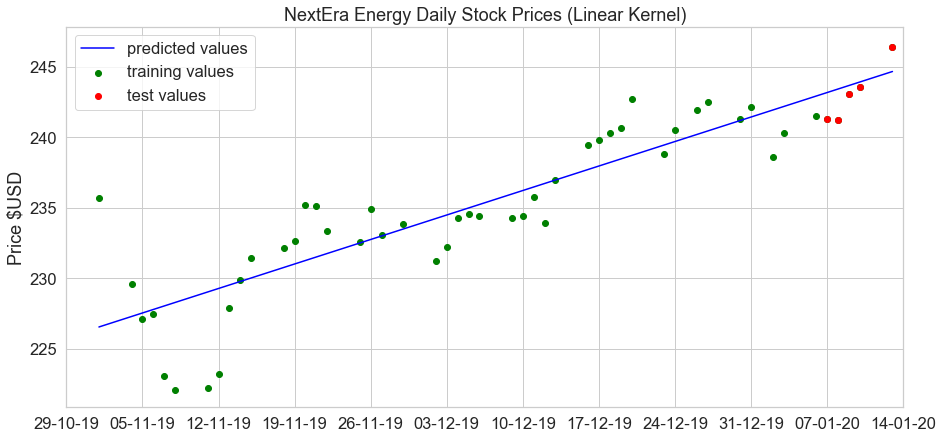

In [203]:
# Predicting y_test values with X_test with linear kernel

svr_linear = SVR(kernel='linear', C=.01, gamma=0.001) 
svr_linear.fit(X_train, y_partune)
y_pred_linear = svr_linear.predict(X)

%matplotlib inline
sns.set(font_scale=1.5, style="whitegrid")
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dt['Dates'], y, color = 'green', label = 'training values')
ax.scatter(dt.iloc[-5:,1], dt.iloc[-5:,0], color = 'red', label = 'test values')
ax.plot(dt['Dates'], y_pred_linear, color = 'blue', label = 'predicted values')
ax.legend()
ax.set_title('NextEra Energy Daily Stock Prices (Linear Kernel)')
ax.set_ylabel('Price $USD')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
ax.set_xlim((np.datetime64(start_date) - np.timedelta64(3,'D')),(np.datetime64(end_date)+ np.timedelta64(1,'D')) )
plt.show()


In [207]:
# Comparing a GridSearchCV when kernel = 'poly'. Due to long run times in the 
# GridSearchCV the number of folds were reduced to k = 5 and the degree, C and gamma options
# for the GridSearchCV have initially been reduced before arriving at the final set of 
# potential parameters entered into the GridSearchCV below.

warnings.filterwarnings("ignore")

y_partune = np.ravel(y_train)
Cs = [.1, 1]
gammas = [0.001, 0.1]
degrees = [2,3]
param_grid = {'degree': degrees, 'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVR(kernel = 'poly'), param_grid, cv=5)
grid_search.fit(X_train, y_partune)
grid_search.best_params_

{'C': 0.1, 'degree': 3, 'gamma': 0.001}

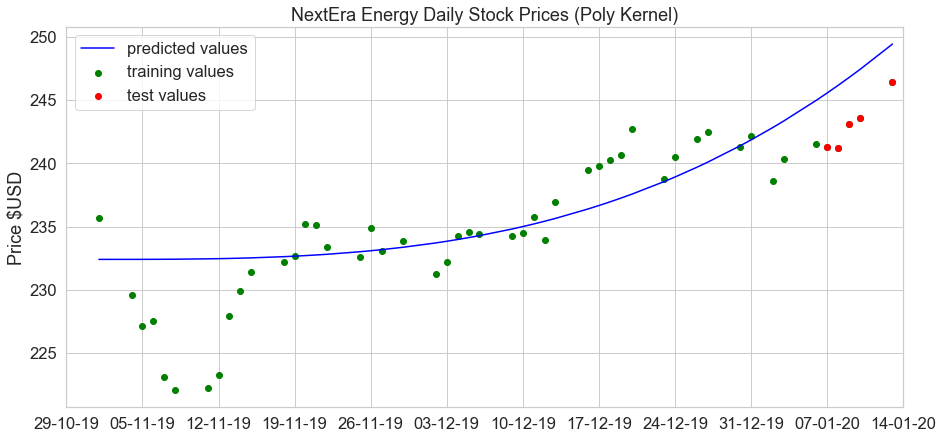

In [204]:
# Predicting y_test values with X_test with polynomial kernel

svr_poly = SVR(kernel='poly', degree = 3, C=.1, gamma=.001)
svr_poly.fit(X_train, y_partune)
svr_poly.score(X_train, y_partune)
y_pred_poly  = svr_poly.predict(X)

%matplotlib inline
sns.set(font_scale=1.5, style="whitegrid")
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dt['Dates'], y, color = 'green', label = 'training values')
ax.scatter(dt.iloc[-5:,1], dt.iloc[-5:,0], color = 'red', label = 'test values')
ax.plot(dt['Dates'], y_pred_poly, color = 'blue', label = 'predicted values')
ax.legend()
ax.set_title('NextEra Energy Daily Stock Prices (Poly Kernel)')
ax.set_ylabel('Price $USD')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
ax.set_xlim((np.datetime64(start_date) - np.timedelta64(3,'D')),(np.datetime64(end_date)+ np.timedelta64(1,'D')) )
plt.show()

Visually, the predicted NextEra Energy stock prices using the SVR models with a linear kernel and a RBF kernel appear to be similiar in closeness to true prices. R-squared and mean squared error values will be used to compare model accurary.

In [194]:
# Compare r-squared scores accross the three kernels for testing data.

#r-squared score for the linear model based on test data
print(svr_linear.score(X_test, y_test))

#r-squared score for the rbf model based on test data
print(svr_rbf.score(X_test, y_test))


0.22734625080431617
0.6147244699583777


In [197]:
# COmpare mean squared errors for test data

# Mean squared error for linear model based on test data
y_pred1 = svr_linear.predict(X_test)
print(mean_squared_error(y_test, y_pred1))

#Mean squared error for rbf model based on test data
y_pred2  = svr_rbf.predict(X_test)
print(mean_squared_error(y_test, y_pred2))

2.7670559039383535
1.3797628383404792


As it can be seen from the graphs, r-squared test and mean squared errors, the rbf kernel predicts the NextEra Energy's energy from January 8, 2020 to January 13 2020 most accurately out of the three SVR models. However, an r-squared score of .6147 leaves room for improvement as about 39% of the variance in the data is not explained by the model. Therefore, it would beneficial to explore additional machine learning models as well as include more data in order to predict stock prices.